# ANN OIL PRODUCTION FORECASTING

#### Developed by David Nnamdi and Victor Adelaja

# IMPORT ALL DEPENDENCIES 

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from matplotlib import rcParams
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.optimize import least_squares
np.random.seed(12)

# IMPORT INPUT DATA SET

In [2]:
filename = input('what is file name? ')
address = 'C:\\directory' + filename + '.xlsx'
column_heads= ['Date', 'Oil', 'WC', 'FTHP', 'Beansize', 'GOR']
df = pd.read_excel(address, names=column_heads)
ur = np.float(input('what is UR in MMSTB?')) * 1000000
df.head()

what is file name? 5sn sing
what is UR in MMSTB?3


,Date,Oil,WC,FTHP,Beansize,GOR
0,2014-02-03,778.207757,0.000767,1200,16,449.686831
1,2014-02-04,819.090716,0.000105,1400,16,649.679302
2,2014-02-05,768.494231,0.002441,1700,16,768.004232
3,2014-02-06,989.889626,0.002686,1800,20,1453.461704
4,2014-02-07,1034.840964,0.001677,1850,20,1269.520962


# DATA PREPARATION & ANALYSIS 

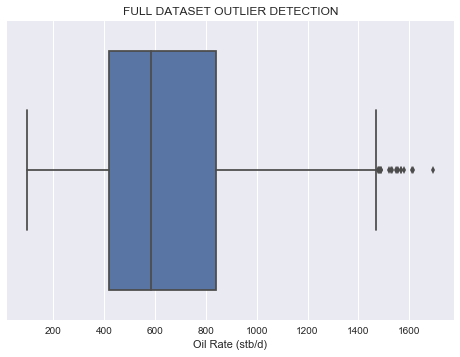

No. of dropped rows:  529



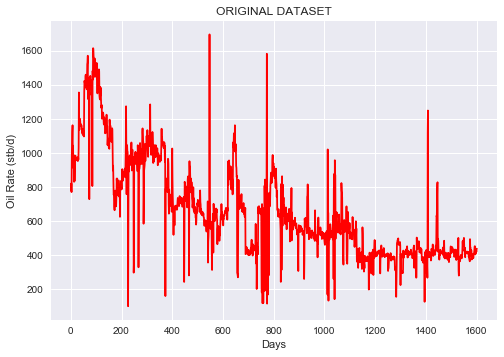

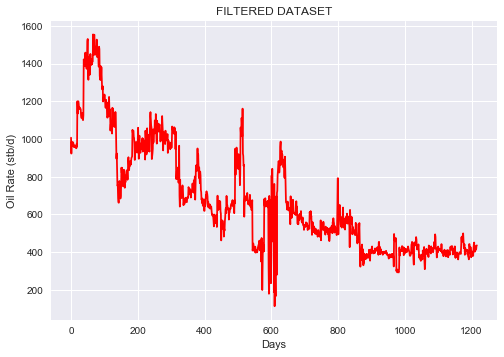

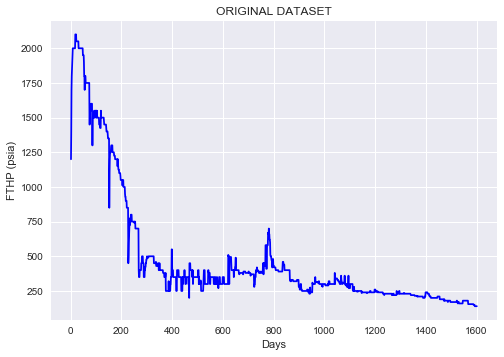

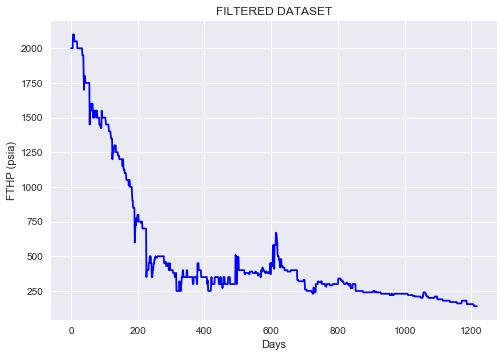

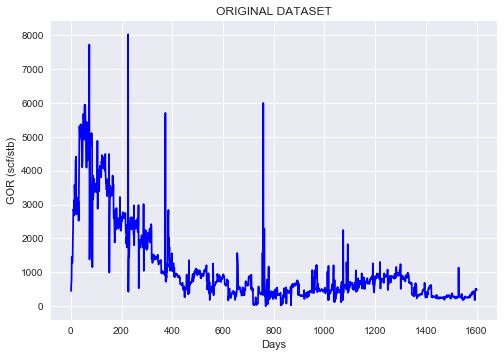

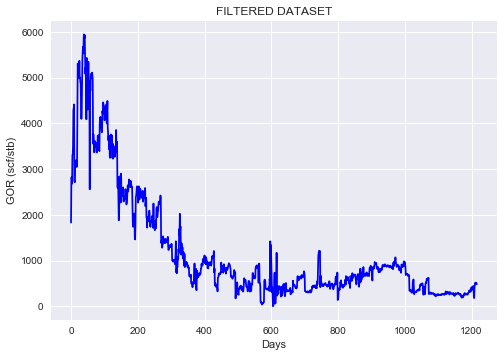

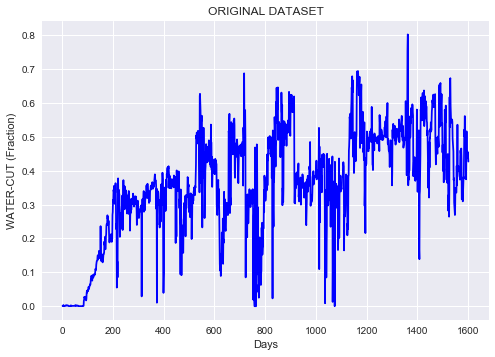

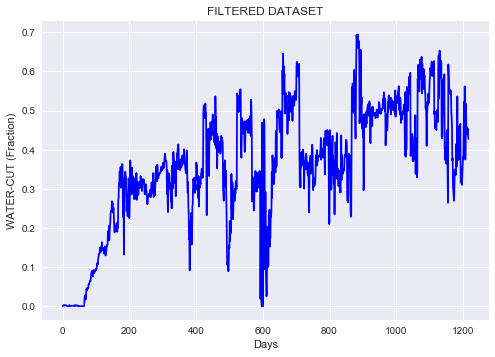

New UR:  2.77


In [3]:
#Generate boxplot showing Outliers
sns.boxplot(x=df['Oil'])
plt.title('FULL DATASET OUTLIER DETECTION')
plt.xlabel('Oil Rate (stb/d)')
plt.show()

#ORIGINAL DATA BEFORE APPLICATION OF OUTLIER DETETCTION ALGORITH
uncleanoil = df['Oil']
uncleanfthp = df['FTHP']
uncleangor = df['GOR']
uncleanwc = df['WC']

#IQR OUTLIER DETECTION ALGORITHM
#The factors for the upper and lower bounds can be changed to meet filter requirements
droplist = []
nn = 30
for i in np.arange(nn,len(df),nn):
    df_o1 = df['Oil'][i-nn:i]
    Q1 = df_o1.quantile(0.25)
    Q3 = df_o1.quantile(0.75)
    IQR = Q3-Q1
    droplist = np.append(droplist, df_o1[df_o1>Q3+1.5*IQR].index)
    droplist = np.append(droplist, df_o1[df_o1<Q1-1.3*IQR].index)
    df_f1 = df['FTHP'][i-nn:i]
    Q1f = df_f1.quantile(0.25)
    Q3f = df_f1.quantile(0.75)
    IQRf = Q3f-Q1f
    droplist = np.append(droplist, df_f1[df_f1>Q3f+1.5*IQRf].index)
    droplist = np.append(droplist, df_f1[df_f1<Q1f-1.5*IQRf].index)
    df_f2 = df['GOR'][i-nn:i]
    Q1g = df_f2.quantile(0.25)
    Q3g = df_f2.quantile(0.75)
    IQRg = Q3g-Q1g
    droplist = np.append(droplist, df_f2[df_f2>Q3g+1.5*IQRg].index)
    droplist = np.append(droplist, df_f2[df_f2<Q1g-1.5*IQRg].index)
    df_f3 = df['WC'][i-nn:i]
    Q1w = df_f3.quantile(0.25)
    Q3w = df_f3.quantile(0.75)
    IQRw = Q3w-Q1w
    droplist = np.append(droplist, df_f3[df_f3>Q3w+1.5*IQRw].index)
    droplist = np.append(droplist, df_f3[df_f3<Q1w-1.5*IQRw].index)


#Generate Filtered Dataset by dropping rows containing outlier data
df_o2 = df.drop(droplist)
clean_oil2 = df_o2['Oil']
clean_fthp = df_o2['FTHP']
clean_gor = df_o2['GOR']
clean_wc = df_o2['WC']
c_time2 = np.arange(0,len(clean_oil2))

#Print number of outlier data rows dropped from original dataset
print('No. of dropped rows: ', len(droplist))
print()

    
#GENERATE BEFORE AND AFTER PLOTS FOR ALL FILTERED PROPERTIES (OIL, FTHP, GOR, WATER-CUT)
#OIL
plt.plot(np.arange(1,len(uncleanoil)+1),df['Oil'],'r')
plt.ylabel('Oil Rate (stb/d)')
plt.xlabel('Days')
plt.title('ORIGINAL DATASET')
plt.show()

plt.plot(c_time2,clean_oil2, 'r')
plt.ylabel('Oil Rate (stb/d)')
plt.xlabel('Days')
plt.title('FILTERED DATASET')
plt.show()


#FTHP
plt.plot(np.arange(1,len(uncleanfthp)+1),uncleanfthp,'b')
plt.ylabel('FTHP (psia)')
plt.xlabel('Days')
plt.title('ORIGINAL DATASET')
plt.show()

plt.plot(c_time2,clean_fthp,'b')
plt.ylabel('FTHP (psia)')
plt.xlabel('Days')
plt.title('FILTERED DATASET')
plt.show()


#GOR
plt.plot(np.arange(1,len(uncleangor)+1),uncleangor,'b')
plt.ylabel('GOR (scf/stb)')
plt.xlabel('Days')
plt.title('ORIGINAL DATASET')
plt.show()

plt.plot(c_time2,clean_gor,'b')
plt.ylabel('GOR (scf/stb)')
plt.xlabel('Days')
plt.title('FILTERED DATASET')
plt.show()

#WATER-CUT
plt.plot(np.arange(1,len(uncleanwc)+1),uncleanwc,'b')
plt.ylabel('WATER-CUT (Fraction)')
plt.xlabel('Days')
plt.title('ORIGINAL DATASET')
plt.show()

plt.plot(c_time2,clean_wc,'b')
plt.ylabel('WATER-CUT (Fraction)')
plt.xlabel('Days')
plt.title('FILTERED DATASET')
plt.show()

#REDUCE ULTIMATE RECOVERY BY SUM OF TOTAL OIL RATE DROPPED IN FILTERED DATA 
#This is done to keep RUR consistent especially during the forecast period
ur =  ur - df['Oil'][set(droplist)].values.sum()
print('New UR: ', round(ur/1000000,2))

#SET ORIGINAL DATASET = CLEAN DATA 
#Therefore if this code is run again, the filtered dataset will now be the original dataset
#and more outliers not removed in the previous pass can be cleaned out
df = df_o2
df.index = np.arange(0,len(df))



# GENERATE PERFORMANCE PLOT

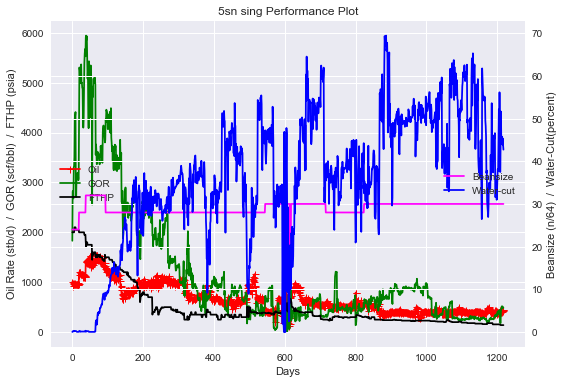

In [4]:
#Generate Performance plot which gives a visual overview of well KFI history
length = np.arange(1, len(df['Oil'])+1)
fig, ax1 = plt.subplots()
ax1.plot(length, df['Oil'], 'r', label='Oil', marker='+', mew=1)
ax1.plot(length, df['GOR'], 'g', label='GOR')
ax1.plot(length, df['FTHP'], 'black', label='FTHP')
ax1.set_title(filename + ' Performance Plot')
ax1.set_xlabel('Days')
ax1.set_ylabel('Oil Rate (stb/d)  /  GOR (scf/bbl)  /  FTHP (psia)')
ax1.legend(loc=6)
ax2 = ax1.twinx()
ax2.plot(length, df['Beansize'], 'magenta', label='Beansize')
ax2.plot(length, df['WC']*100, 'blue', label='Water-cut')
ax2.set_ylabel('Beansize (n/64)  /  Water-Cut(percent)')
ax2.legend(loc=5)
fig.tight_layout()
plt.show()

# COMPUTE APPROX RUR FOR FILTERED DATASET AND
#  GENERATE KFI CORRELATION PANEL

The KFI correlation panel gives insight into how individual well API relates and may be analyzed for further insight into well production performance

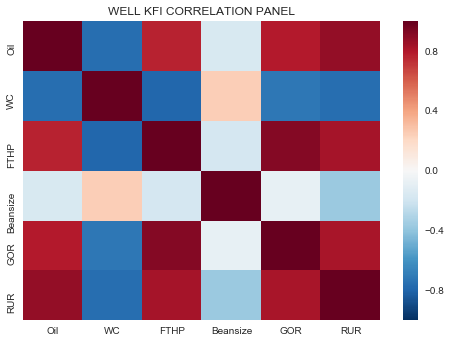

In [5]:
#Generate an approximate RUR history based on filtered dataset and UR
rur = DataFrame((ur - df['Oil'].cumsum()).values/1000000, columns=['RUR'])
df = pd.concat([df,rur], axis=1)

#SHOW CORR PANEL FOR WELL DECLINE ANALYSIS
sns.heatmap(df.corr())
plt.title('WELL KFI CORRELATION PANEL')
plt.show()

# ALGORITHM FOR HYPER-PARAMETER SELECTION

Algorithm combines all possible hyperparameter values and generates loss value for each run. It utilizes early stopping to increase efficiency in evaluating the best hyperparameter combination for training

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, Callback
from tqdm import tqdm
from keras.optimizers import Adam, RMSprop, SGD, Adagrad
from keras.callbacks import EarlyStopping
import os
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras import backend as K
import numpy as np
import tensorflow as tf
import random as rn
from keras import regularizers


class OptimizedAnnNonLinearRegression:

    def __init__(self, data_x, data_y, validation_data_start_index, hidden_layer_range=(1, 2),
                 neuron_count_range=(8, 32), learning_rate_range=(0, 0), batch_size_list=[32],
                 dropout_list=[0.3], activation='relu', optimizer='adam'):

        np.random.seed(12)
        rn.seed(12345)
        tf.set_random_seed(1234)
        self.data_x = data_x
        self.data_y = data_y
        self.learning_rate_range = learning_rate_range
        self.learning_rates = []
        self.hidden_layer_counts = []
        self.neurons_per_layer = []
        self.batch_size_list = []
        self.combinations = []
        self.activation = activation
        self.epochs = 5000
        self.optimizer_name = optimizer
        self.losses_and_filepaths = {}
        self.losses_and_combination = {}
        self.feature_count = len(self.data_x[0])
        self.hist = None
        self.model = None

        if len(hidden_layer_range) == 2:
            self.hidden_layer_min = hidden_layer_range[0]
            self.hidden_layer_max = hidden_layer_range[1]
        else:
            self.hidden_layer_min = hidden_layer_range
            self.hidden_layer_max = hidden_layer_range
        i = self.hidden_layer_min
        while i <= self.hidden_layer_max:
            self.hidden_layer_counts.append(i)
            i += 1

        if len(neuron_count_range) == 2:
            self.neuron_count_min = neuron_count_range[0]
            self.neuron_count_max = neuron_count_range[1]
        else:
            self.neuron_count_min = neuron_count_range
            self.neuron_count_max = neuron_count_range
        i = self.neuron_count_min
        while i <= self.neuron_count_max:
            self.neurons_per_layer.append(i)
            i *= 2

        if learning_rate_range != (0, 0):
            if len(learning_rate_range) == 2:
                self.learning_rate_min = learning_rate_range[0]
                self.learning_rate_max = learning_rate_range[1]
            else:
                self.learning_rate_min = learning_rate_range
                self.learning_rate_max = learning_rate_range
            i = self.learning_rate_min
            while i <= self.learning_rate_max:
                self.learning_rates.append(i)
                i *= 10
        else:
            self.learning_rate_min = 0
            self.learning_rate_max = 0
            self.learning_rates.append(0)

        self.batch_size_list = batch_size_list

        self.scalers_x = []
        self.scaler_x = StandardScaler()
        self.data_x = self.scaler_x.fit_transform(self.data_x)

        self.train_x = self.data_x[:validation_data_start_index]
        self.valid_x = self.data_x[validation_data_start_index:]

        self.scaler_y = StandardScaler()
        self.data_y = self.scaler_y.fit_transform(self.data_y.reshape(-1, 1))

        self.train_y = self.data_y[:validation_data_start_index]
        self.valid_y = self.data_y[validation_data_start_index:]

        for i in range(len(self.learning_rates)):
            for j in range(len(self.hidden_layer_counts)):
                for k in range(len(self.neurons_per_layer)):
                    for l in range(len(self.batch_size_list)):
                        for m in range(len(dropout_list)):
                            combination = []
                            combination.append(self.learning_rates[i])
                            combination.append(self.hidden_layer_counts[j])
                            combination.append(self.neurons_per_layer[k])
                            combination.append(self.batch_size_list[l])
                            combination.append(dropout_list[m])
                            self.combinations.append(combination)

        self.optimizer = optimizer

    def getPathFromCombination(self, combination):
        path = ""
        for val in combination:
            path += str(val)
        return path

    def getModelFromCombination(self, combination):
        model = Sequential()
        
        learn_rate = combination[0]
        layers = combination[1]
        neurons = combination[2]
        batchsize = combination[3]
        dropout = combination[4]
        
        model.add(Dense(neurons, activation=self.activation, input_dim=len(self.train_x[0]), 
                        kernel_regularizer=regularizers.l2(l = 0.001)))
        if dropout != 0 and dropout is not None:
            model.add(Dropout(dropout))
        for i in range(layers - 1):
            model.add(Dense(neurons, activation=self.activation, kernel_regularizer=regularizers.l2(l = 0.001)))
            if dropout != 0 and dropout is not None:
                model.add(Dropout(dropout))
        model.add(Dense(1))

        if self.learning_rate_range != (0, 0) and self.learning_rate_range is not None:
            if self.optimizer_name == 'adam':
                self.optimizer = Adam(lr=learn_rate)
            elif self.optimizer_name == 'rmsprop':
                self.optimizer = RMSprop(lr=learn_rate)
            elif self.optimizer_name == 'adagrad':
                self.optimizer = Adagrad(lr=learn_rate)
            else:
                self.optimizer = SGD(lr=learn_rate)
        else:
            if self.optimizer_name == 'adam':
                self.optimizer = Adam()
            elif self.optimizer_name == 'rmsprop':
                self.optimizer = RMSprop()
            elif self.optimizer_name == 'adagrad':
                self.optimizer = Adagrad()
            else:
                self.optimizer = SGD()

        model.compile(loss='mean_squared_error', optimizer="Adam",
                      metrics=['mae', 'acc'])
        return model

    def beginOptimization(self):

        os.makedirs("NLRWeights/", exist_ok=True)

        for i in tqdm(range(len(self.combinations))):
            del self.model
            K.clear_session()
            combination = self.combinations[i]

            self.model = self.getModelFromCombination(combination)
            path = self.getPathFromCombination(combination)

            filepath = "NLRWeights/" + path + "-{val_loss:.4f}.hdf5"
            checkpointer = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False)

            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=300,
                                           verbose=0, mode='auto')
            self.hist = self.model.fit(self.train_x, self.train_y, epochs=self.epochs,
                                  validation_data=(self.valid_x, self.valid_y),
                                  batch_size=combination[3], verbose=0, callbacks=[checkpointer, early_stopping])
            val_loss = "{0:.4f}".format(min(self.hist.history['val_loss']))
            self.losses_and_combination[val_loss] = combination
            for loss in self.hist.history['val_loss']:
                loss = "{0:.4f}".format(loss)
                del_path = "NLRWeights/" + path + "-" + loss + ".hdf5"
                if loss != val_loss and os.path.exists(del_path):
                    os.remove(del_path)
                elif loss == val_loss:
                    self.losses_and_filepaths[loss] = del_path
    
        min_loss = min(self.losses_and_combination.keys())
        min_config = self.losses_and_combination[min_loss]
        for loss in self.losses_and_combination.keys():
            del_path = self.losses_and_filepaths[loss]
            if loss != min_loss and os.path.exists(del_path):
                os.remove(del_path)
            elif loss == min_loss:
                new_path = "NLRWeights/best-model.hdf5"
                if os.path.exists(new_path):
                    os.remove(new_path)
                os.rename(del_path, new_path)
                
        del self.model
        K.clear_session()
        
        self.model = self.getModelFromCombination(min_config)
        self.model.load_weights("NLRWeights/best-model.hdf5")
        self.model.save("NLRWeights/best-model.hdf5")
        self.hist = None
        self.losses_and_combination = None
        print("Optimization Completed Successfully! Best Model Loaded.")
        print("Best Configuration")
        print(self.model.summary())
        print()
        print("Loss Value: " + str(min_loss))
        if self.learning_rate_range != (0, 0) and self.learning_rate_range is not None:
            print("Learning Rate: " + str(min_config[0]))
        print("Batch Size: " + str(min_config[3]))
        print("Dropout: " + str(min_config[4]))
    
    def load_model(self, filepath):
        self.model = load_model(filepath)

    def predict(self, pred_x):
        if len(pred_x[0]) == self.feature_count:
            pred_x = self.scaler_x.transform(pred_x)
            predictions = self.model.predict(pred_x)
            pred_values = self.scaler_y.inverse_transform(predictions.reshape(-1, 1))
            return pred_values
        else:
            print("Feature count mismatch. Train: " + str(self.feature_count) + " Pred: " + str(len(pred_x[0])))
            


# SPLIT DATASET INTO TRAIN/TEST

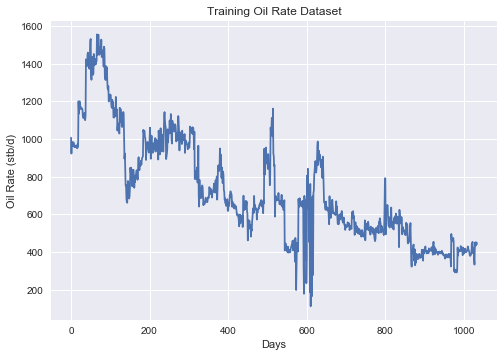

In [7]:
#To USE ANN, WE MUST FIRST SPLIT OUR DATA INTO TRAINING(WHICH WILL CONTAIN VALIDATION DATA) AND TEST DATASET
#THE X VARIABLE IS THE KFI TO BE TRAINED/TESTED, THE Y IS THE CORRESPONDING OIL RATE
x = df.iloc[:, 2:]
y = df.iloc[:, 1]
split = int(len(x)*0.85)
x_train, x_test, y_train, y_test = x[:split], x[split:], y[:split], y[split:]

#plot training oil rate vs time
plt.plot(np.arange(0, len(x_train)), y_train)
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('Training Oil Rate Dataset')
plt.show()


# SET MODEL PARAMETER RANGE AND RUN MODEL

-> SHOW MATCH WITH TEST DATA

100%|████████████████████████████████████████████| 2/2 [00:23<00:00, 11.19s/it]


Optimization Completed Successfully! Best Model Loaded.
Best Configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
None

Loss Value: 0.0366
Learning Rate: 0.001
Batch Size: 300
Dro

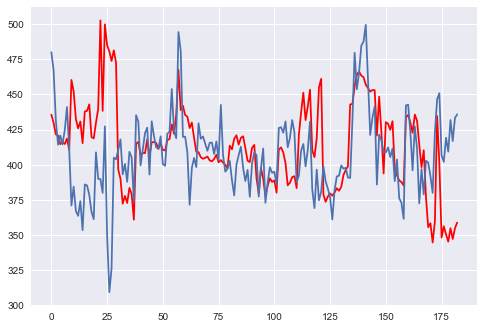

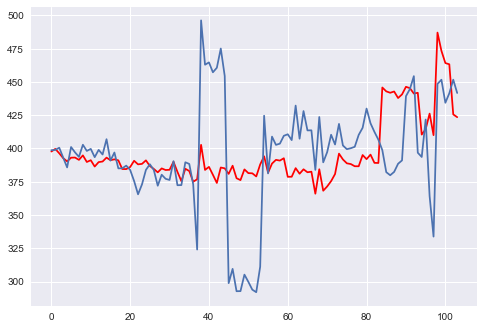

In [16]:
#Define the model parameters to be used in the NNS Optimizer
#As prescribed in the paper, it is advisable to use smaller ranges of hyperparameters and take note of the 
# best performing ones as opposed to using a very large range which may be computationally intensive
mdl = OptimizedAnnNonLinearRegression(x_train.values, y_train.values, int(len(x_train)*0.9), hidden_layer_range=(2, 2),
                 neuron_count_range=(32,64), learning_rate_range=(0.001, 0.001), batch_size_list=[300],
                 dropout_list=[0.5], activation='relu', optimizer='adam')

#Once hyperparameters have been defined, begin the optimization process
mdl.beginOptimization()

#Run trained ANN model on test KFI data and plot predicted oil rate vs actual oil production(test data)
# This will aid to visually examine model prediction performance
newy = mdl.predict(x_test.values)
nxxx = np.arange(0,len(newy))
plt.plot(nxxx, newy, 'r')
plt.plot(nxxx, y_test)
plt.show()

#Run trained model on the Validation data to see how well it performed during training and validation in the NNS optimizer
# The plot also serves to visually examime model performance and compare validation data performance to test data performance
x_val = x_train[int(len(x_train)*0.9):]
y_val = y_train[int(len(x_train)*0.9):]
y_pval = mdl.predict(x_val.values)
n_val = np.arange(0,len(x_val))
plt.plot(n_val, y_pval, 'r')
plt.plot(n_val, y_val)
plt.show()

# MODEL PREDICTION ON TEST AND TRAIN DATASET

In [17]:
#Run and save model prediction on test data and training data for plotting purposes 
y_predd = mdl.predict(x_test.values)
y_pp =mdl.predict(x_train.values)
amen = np.arange(1, len(y)+1)
nd = pd.DataFrame(amen[split:])[0]
nd2 = pd.DataFrame(amen[:split])[0]

# COMPARISON OF TRAINED ANN WITH ARPS DCA ON TEST DATA

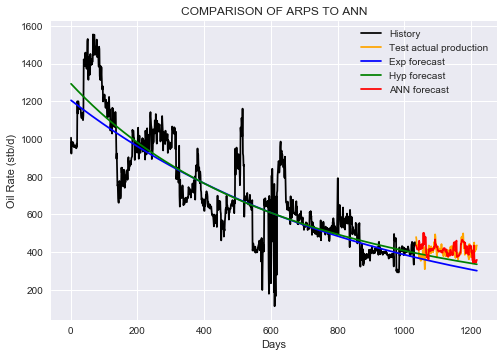

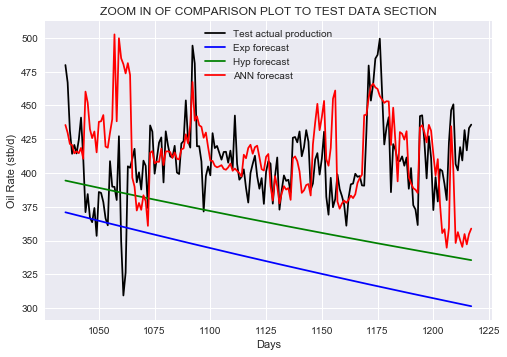

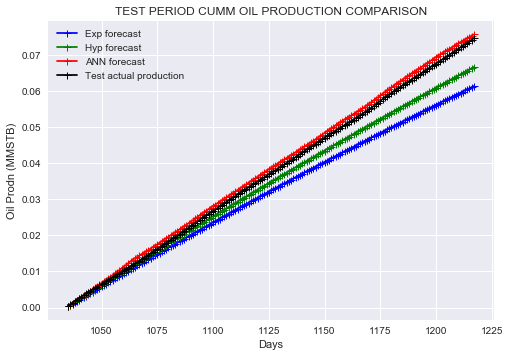

MSE:  [6630.26 3136.57 1468.64]
RMSE:  [81.43 56.01 38.32]
MAPE:  [17.72 11.43  6.84]
PE:  [-17.35 -10.23   1.8 ]


In [18]:
# Generate forecast time, historical datasets for plotting and forecast purposes
d_oil = y_train
d_time = nd2
f_time = nd
t_time = np.append(nd2.values,nd.values)

#The following lines of code detail generating ARPS decline curves for the well production and compare to the ANN forecast

#create docker lists for storing errors at every stage
MSE = []
RMSE = []
MAPE = []
PE = []

#SET DAY TO START GENERATING ARPS DECLINE CURVES
lt = 0

#ARPS EXPONENTIAL DECLINE CURVES AND EVALUATION OF ERRORS
logoil = np.log(d_oil)
slope, intercept, r_value, p_value, std_err = stats.linregress(d_time[lt:],logoil[lt:])
ss1 = slope
int1 = intercept
exp_q = np.exp(ss1*t_time + int1)
exp_q1 = np.exp(ss1*f_time + int1)
MSE_exp = sum((y_test.values-exp_q1.values)**2)/len(y_test)
RMSE_exp = MSE_exp**0.5
MAPE_exp = (sum(abs((y_test.values-exp_q1.values)/y_test.values))/len(y_test)) * 100
PE_exp = sum((exp_q1.values-y_test.values)/y_test.values)/len(y_test)* 100
MSE = np.append(MSE, MSE_exp)
RMSE = np.append(RMSE, RMSE_exp)
MAPE = np.append(MAPE, MAPE_exp)
PE = np.append(PE, PE_exp)
cum_exp = exp_q1.cumsum()/1000000


#ARPS HYPERBOLIC DECLINE CURVES AND EVALUATION OF ERRORS
def hyperb(x,r,t):
    return (x[0] * (1/((1+ x[1]*x[2]*t)**(1/x[1])))-r)
bounds = (0,[np.inf, 1., np.inf])
x0 = np.array([1, 0.5, 1])
res_lsq1 = least_squares(hyperb, x0, args=(d_oil[lt:], d_time[lt:]), bounds=bounds)
exp1 = res_lsq1.x[0]
exp2 = res_lsq1.x[1]
exp3 = res_lsq1.x[2]
hyp_q = exp1 * (1/((1+ exp2*exp3*t_time)**(1/exp2)))
hyp_q1 = exp1 * (1/((1+ exp2*exp3*f_time)**(1/exp2)))
MSE_hyp = sum((y_test.values-hyp_q1.values)**2)/len(y_test)
RMSE_hyp = MSE_hyp**0.5
MAPE_hyp = (sum(abs((y_test.values-hyp_q1.values)/y_test.values))/len(y_test)) * 100
PE_hyp = sum((hyp_q1.values-y_test.values)/y_test.values)/len(y_test)* 100
MSE = np.append(MSE, MSE_hyp)
RMSE = np.append(RMSE, RMSE_hyp)
MAPE = np.append(MAPE, MAPE_hyp)
PE = np.append(PE, PE_hyp)
cum_hyp = hyp_q1.cumsum()/1000000

#ANN FORECAST AND EVALUATION OF ERRORS
y_predd1 = pd.DataFrame(y_predd)[0]
y_predd1.index = y_test.index
y_predd1
MSE_ann = sum((y_test-y_predd1)**2)/len(y_test)
RMSE_ann = MSE_ann**0.5
MAPE_ann = (sum(abs((y_test-y_predd1)/y_test))/len(y_test)) * 100
PE_ann = sum((y_predd1.values-y_test.values)/y_test.values)/len(y_test)* 100
MSE = np.append(MSE, MSE_ann)
RMSE = np.append(RMSE, RMSE_ann)
MAPE = np.append(MAPE, MAPE_ann)
PE = np.append(PE, PE_ann)
cum_ann = y_predd.cumsum()/1000000

#ACTUAL CUMMULATIVE PRODUCTION FROM TEST DATA
cum_actual = y_test.cumsum()/1000000

#Comparison plot of historical data + forecast from Arps decline equations and ANN
plt.plot(d_time, d_oil, 'black', label='History')
plt.plot(nd, y_test, 'orange', label='Test actual production')
plt.plot(t_time[lt:],  exp_q[lt:], 'blue',label='Exp forecast')
plt.plot(t_time[lt:], hyp_q[lt:], 'g',  label='Hyp forecast')
plt.plot(nd, y_predd, 'r', label ='ANN forecast')
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('COMPARISON OF ARPS TO ANN')
plt.legend(loc='best')
plt.show()


#Zoom in of comparison plot on test data forecat by trained ANN vs Arps DCA eqns
plt.plot(nd, y_test, 'black',label='Test actual production')
plt.plot(f_time, exp_q1, 'blue',label='Exp forecast')
plt.plot(f_time, hyp_q1, 'g',label='Hyp forecast')
plt.plot(nd, y_predd, 'r',label ='ANN forecast')
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('ZOOM IN OF COMPARISON PLOT TO TEST DATA SECTION')
plt.legend(loc='best')
plt.show()

#The corresponding cumulative oil production predicted within the test data period by trained ANN
# and Arps DCA eqns
plt.plot(f_time, cum_exp, 'blue',label='Exp forecast',marker='+', mew=1)
plt.plot(f_time, cum_hyp, 'g',label='Hyp forecast',marker='+', mew=1)
plt.plot(nd, cum_ann, 'r', label ='ANN forecast',marker='+', mew=1)
plt.plot(nd, cum_actual, 'black',label ='Test actual production',marker='+', mew=1)
plt.xlabel('Days')
plt.ylabel('Oil Prodn (MMSTB)')
plt.title('TEST PERIOD CUMM OIL PRODUCTION COMPARISON')
plt.legend(loc='best')
plt.show()

#Print all errors evaluated based on forecast and test data
# for each error type array, the first data represents the Arps exponential, the 2nd and 3rd are
# the hyperbolic and ANN errors respectively
print('MSE: ', np.round(MSE,2))
print('RMSE: ', np.round(RMSE,2))
print('MAPE: ', np.round(MAPE,2))
print('PE: ', np.round(PE,2))

# DEFINE TIME STEPS FOR GRAPHING PURPOSES
PLEASE NOTE THAT THESE TIMESTEPS ARE NOT IN ANYWAY USED IN TRAINING OR FORECASTING WITH ANN

In [19]:
# This is done because each production data in the filtered set must be assigned to a timestep
# it is this time step that will guide in forecasting KFI profiles when a satisfactorily trained ANN has been obtained
x['Days']=pd.DataFrame(amen)[0]

# RUN FORECAST AND TEST FOR DIFFERENT SCENARIOS

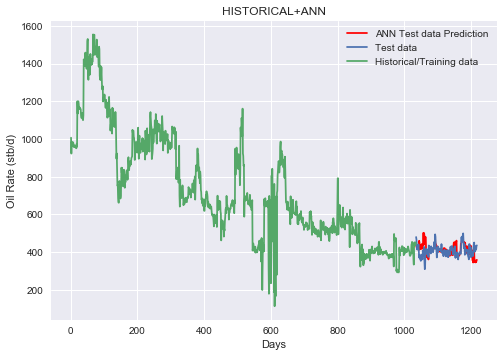

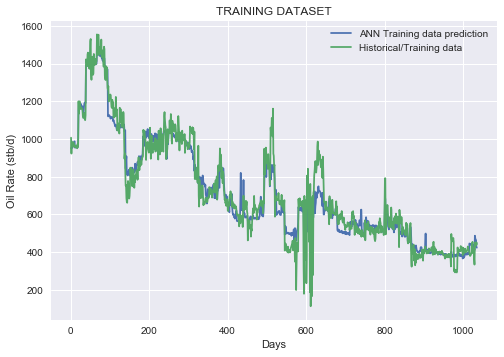

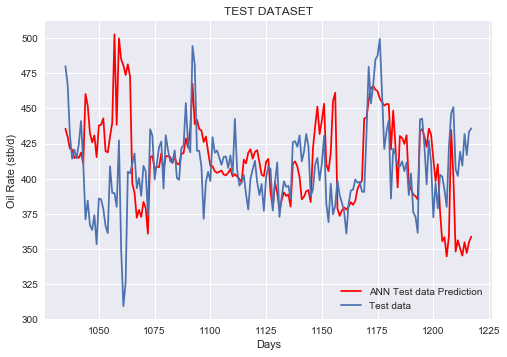

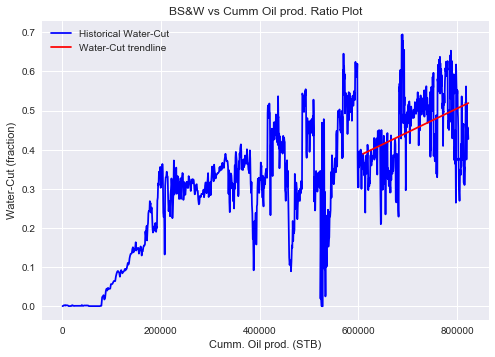

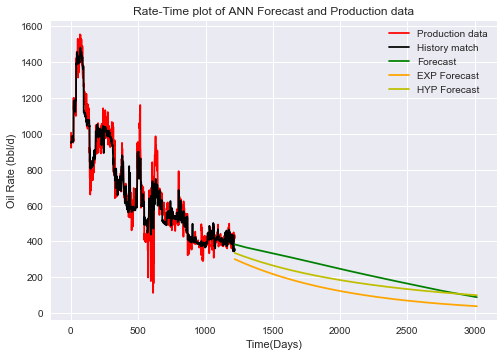

GOR:  291 SCF/STB
cum oil prod:  0.414 MMSTB
No. of days predicted:  1800 days
Constant FTHP forecast


In [23]:
#Plot the historical and ANN predicted values for the training and test dataset for visual comparison
plt.plot(nd, y_predd,'r', label='ANN Test data Prediction')
plt.plot(nd, y_test, label='Test data')
plt.plot(nd2, y_train, label='Historical/Training data')
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('HISTORICAL+ANN')
plt.legend(loc='best')
plt.show()

#Plot the historical and ANN predicted values for the training dataset for visual comparison
plt.plot(nd2, y_pp, label='ANN Training data prediction')
plt.plot(nd2, y_train, label='Historical/Training data')
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('TRAINING DATASET')
plt.legend(loc='best')
plt.show()

#Plot ANN forecast for test data vs actual historical production for visual comparison
plt.plot(nd, y_predd,'r', label='ANN Test data Prediction')
plt.plot(nd, y_test, label='Test data')
plt.xlabel('Days')
plt.ylabel('Oil Rate (stb/d)')
plt.title('TEST DATASET')
plt.legend(loc='best')
plt.show()



# GENERATE A LINER REGRESSION EQN FOR FORECASTING WATER PRODUCTION
# this is based on water-cut vs Oil cum profiles 
bsw = df['WC'].values
cummoil = df['Oil'].cumsum().values

# lt is a splitting factor for the BSW to determine where you want to start a linear regression for
# the 0.2 represents 20% of the full dataset and this value can be changed at will based on montoring 
# the regression plot of cumm oil vs bsw plot below
lt=int(len(bsw)*0.6)

#lt2 is a splitting factor to determine what percent of data to be used in computing an average GOR value for forecasting
lt2 = int(len(bsw)*0.9)

#Code for a linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cummoil[lt:],bsw[lt:])
s1 = slope
c1 = intercept
fit_bsw = cummoil*s1 + c1

# Plot cumm oil vs bsw and show trendline fit based on regression above
plt.plot(cummoil, bsw, 'b', label='Historical Water-Cut')
plt.plot(cummoil[lt:], fit_bsw[lt:], 'r', label='Water-Cut trendline')
plt.xlabel('Cumm. Oil prod. (STB)')
plt.ylabel('Water-Cut (fraction)')
plt.title('BS&W vs Cumm Oil prod. Ratio Plot')
plt.legend(loc='best')
plt.show()



# create timestep dataframes for forecast evaluation
forecast_time = 60
d = np.arange(0, int(forecast_time*30))


#BEGIN FORECASTING PROCESS
method = 'c' #This controls the FTHP method used for forecasting, c is for const FTHP, d is for varying based on 
             # user-defined equation or method
slopem = (50-x['FTHP'][len(x['Days'])-1])/(d[-1]-d[0]) #this evaluates a linear slope between last FTHP and a specified one
                                                #at the end of production (in this case 50). 50 can be changed as required
#The dockers below are lists for saving KFI input used in every forecast step
wc = []
fthp = []
bn = []
rur = []
pred = []

#BEGIN FORECAST
for values in d:
    #extract KFI values at last time step in filtered historical data
    aa = x['WC'][len(x['Days'])-1]
    bb = x['FTHP'][len(x['Days'])-1]
    cc = x['Beansize'][len(x['Days'])-1]
    dd = x['RUR'][len(x['Days'])-1]
    if x['GOR'][len(x['Days'])-1] == x['GOR'][0]: #if start GOR = end GOR, reservoir is undersaturated, else it is saturated
        ee = x['GOR'][len(x['Days'])-1] #UnderSaturated GOR
    else:
        ee = x['GOR'][lt2:].mean()  #Saturated, the average GOR for the % of total GOR at timestep is used to forecast
#         ee = x['GOR'].values[-1] ## This may be enabled if user wants to forecast with GOR at historical last timestep  
    # Forecast for the first timestep
    if values == 0:
        wc1 = aa
        fthp1 = bb
        bn1 = cc
        ak = dd
        inp = np.array([ wc1, fthp1, bn1, ee, ak])
        p = inp.reshape(1,5)
        pp = mdl.predict(p) #predict based on input KFI
        pred = np.append(pred,pp)
        rur = np.append(rur,ak)
        wc = np.append(wc, wc1)
        bn = np.append(bn, bn1)
        fthp = np.append(fthp, fthp1)
    #Forecast other timesteps
    else:
        #define FTHP forecast profile (i.e fixed or changing)
        if method == 'd': 
            decln = np.log(bb/150)/len(d)
            fthp1 = bb*np.exp(-decln*values) # use this to generate an exponential FTHP forecast profile (may modify 200) 
#             fthp1 = slopem*(values-d[0]) + bb # use this equation instead to generate a linear changing FTHP profile
        else:
            fthp1 = bb #constant FTHP fore forecast if method == c
        bn1 = np.append(wc,cc)[-1] #bean is kept constant in all forecast, but user may change by modifying code
        if pred[-1]<50: #Economic limit of 50bbls/d, STOP FORECAST. Adjust as required by changing 50
            break
        else:
            tpred = (pred.cumsum()[-1]/1000000)
            Np = tpred + (df['Oil'].cumsum().values[-1]/1000000)
            ak = ur/1000000 - Np
            #Below are several models for predicting watercut. Select equation and unhash as required 
#             wc1 = (Np*1000000)*(s1) + c1
#             wc1= x['WC'][lt:].mean()
#             values = float(values)
#             wc1 = (-3e-16*(values**5))+(6e-13*(values**4))-(1e-10*(values**2))-(6e-8*(values**2))+(4e-5*values)+0.0003
#             wc1 = (2e-10*(values**2))+(1e-5*values)+ 0.3701
#             wc1 = aa
            declnw = np.log(aa/0.99)/len(d) #water model chosen for this forecast is the exponential forecast
            wc1 = aa*np.exp(-declnw*values) #change 0.99 at will
            if wc1 > 1: #Limit of oil production, water-cut = 100% then the well is watered out and oil does not flow
                break
            else:
                inp = np.array([ wc1, fthp1, bn1, ee, ak])
                p = inp.reshape(1,5)
                pp = mdl.predict(p) #predict all forecast for subsequent timesteps in forecast
                pred = np.append(pred,pp)
                if rur[-1]<0: #Another limit, if well's cumm production is = RUR, BREAK FORECAST
                    break
                else:
                    rur = np.append(rur,ak)
            #Ccompile all KFI used in forecasts to the dockers above
            wc = np.append(wc, wc1)
            bn = np.append(bn, bn1)
            fthp = np.append(fthp, fthp1)

#Create time axis for plotting historical and forecast data together
newx = np.arange(0, len(pred))
newxx = newx +x['Days'][len(x['Days'])-1]
Hist = np.append(y_pp, y_predd)
for_t = d+x['Days'][len(x['Days'])-1]

#generate an exponential and hyperbolic forecast for comparison with ANN forecast
exp_pred = np.exp(ss1*for_t + int1)
hyp_pred = exp1 * (1/((1+ exp2*exp3*for_t)**(1/exp2)))


#plot forecast + history
plt.plot(x['Days'], y, 'r', label='Production data')
plt.plot(x['Days'], Hist, 'black', label='History match')
plt.plot(newxx,pred, 'g', label='Forecast')
plt.plot(for_t,exp_pred, 'orange', label='EXP Forecast')
plt.plot(for_t,hyp_pred, 'y', label='HYP Forecast')
plt.ylabel('Oil Rate (bbl/d)')
plt.xlabel('Time(Days)')
plt.title('Rate-Time plot of ANN Forecast and Production data')
plt.legend(loc='best')
plt.show()

#print forecast information
print('GOR: ',round(ee), 'SCF/STB')
print('cum oil prod: ', round(sum(pred)/1000000,3), 'MMSTB')
print('No. of days predicted: ',len(pred), 'days')
if method == 'd':
    print('Varying FTHP forecast')
else:
    print('Constant FTHP forecast')

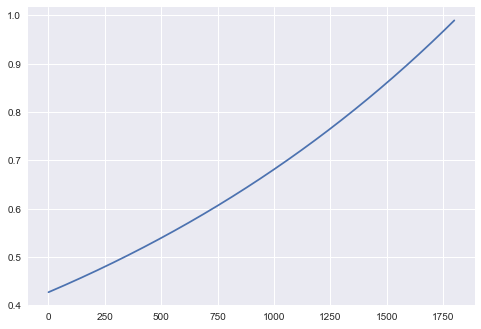

In [21]:
#visualize any KFI profile used in forecast (i.e rur, wc, fthp)
th_p = wc
plt.plot(np.arange(0,len(th_p)), th_p)
plt.show()

# EXTRACT MONTHLY FORECASTS FROM DAILY

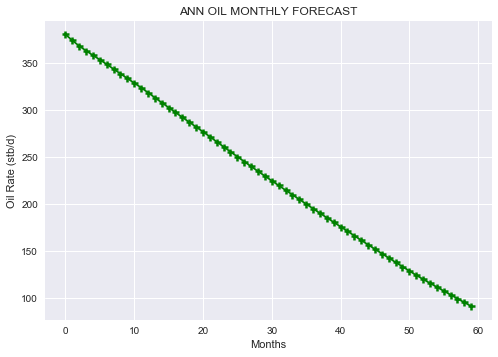

,Forecast Months,Oil Avg rate (bbl/d),Gas Avg rate (Mscf/d),Water Cut Avg
0,2019-Mar,380.696598,110.661536,0.430145
1,2019-Apr,374.361700,108.820097,0.436212
2,2019-May,368.369491,107.078271,0.442365
3,2019-Jun,363.354295,105.620445,0.448604
4,2019-Jul,358.459799,104.197705,0.454931


In [24]:
#Due to large volume of daily data, extract average daily production rates in 30-day intervals
mndn = np.arange(30, len(pred), 30)
#Dockers to save monthly forecast data
dmn = []
mnavg = []
gasavg = []
watavg = []
wcavg = []
for val in mndn:
    avg = pred[val-30:val].mean()
    gavg = avg*ee/1000
    wcm = wc[val-30:val].mean()
    wcavg = np.append(wcavg, wcm)
    wavg = (avg*wcm)/(1-wcm)
    mnavg = np.append(mnavg,avg)
    gasavg = np.append(gasavg, gavg)
    watavg = np.append(watavg, wavg)
    dmn = np.append(dmn, val)
loil = pred[int(dmn[-1]):].mean()
lwat = wc[int(dmn[-1]):].mean()
mnavg = pd.DataFrame(np.append(mnavg, loil), columns=['Oil Avg rate (bbl/d)']).dropna()
gasavg = pd.DataFrame(np.append(gasavg, (loil*ee/1000)), columns=['Gas Avg rate (Mscf/d)']).dropna()
watavg =  pd.DataFrame(np.append(wcavg, lwat), columns=['Water Cut Avg']).dropna()


#Generate forecast months timestep based on last timestep in filtered historical data
kxx = str(df['Date'].values[-1])
yrr = int(kxx[0]+kxx[1]+kxx[2]+kxx[3])
mnnth = int(kxx[5]+kxx[6])
admn = (len(mnavg)-(12-mnnth))
adyr = int(admn/12)
fnmn = admn - adyr*12
if fnmn == 0:
    fnyr = yrr+adyr
    fnmn = 12
else:
    fnyr = yrr+adyr+1
fmonths = pd.date_range(str(yrr)+'-'+str(mnnth+1)+'-'+str(1),
              str(fnyr)+'-'+str(fnmn)+'-'+str(28), 
              freq='MS').strftime("%Y-%b")

pred_mnth = pd.DataFrame(fmonths, columns=['Forecast Months'])


#generate monthly output file for saving 
m_oup = pd.concat([pred_mnth, mnavg, gasavg, watavg], axis=1)

#Plot monthly oil forecast vs time
plt.plot(np.arange(0,len(mnavg)), mnavg.values, 'g', label='Forecast', marker='+', mew=2.5)
plt.title('ANN OIL MONTHLY FORECAST')
plt.xlabel('Months')
plt.ylabel('Oil Rate (stb/d)')
plt.show()

#show first few rows of monthly forecast output dataset
m_oup.head()

# SAVE FORECAST RESULTS

In [85]:
#save results as excel file to the path C:\\Users\\davidnnamdi
name = input('save results as: ')
writer = pd.ExcelWriter(name + ' DAILY ANN FORECAST.xlsx', engine='xlsxwriter')
pd.DataFrame(pred).to_excel(writer, sheet_name='Sheet1')
writer.save()

save results as: 5s sim
